In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import PredictionConfig
from hamp_pred.src.predictor_config import DEFAULT_CONF
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import MultiEncoder, RadiousPhobosEncoder, OneHotEncoderSeq, RadianEncoder

2022-11-15 14:59:07.964655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def get_labels(df):
    # przewidujemy rot per layer
    a = np.vstack(df['rot'].values)
    return (a[:,0::2] + a[:,1::2]) / 2

def diffangle(targetA, sourceA):
    a = targetA - sourceA
    a = (a + 180) % 360 - 180
    return a

### `hamp_rot` model

In [31]:
# test set
pdb_df = pd.read_pickle('~/analysis/TCST/hamp_svm/pdb_measure.p')
train_df = pd.read_pickle('~/analysis/TCST/hamp_ml/cache/af2_true_full.balance.features.p')
trainmask = (train_df['class'] == 'train').values
valmask = (train_df['class'] == 'val').values
valdf = train_df.iloc[valmask, ]
pdb_df.rename(columns={'seq1':'n_seq', 'seq2':'c_seq'}, inplace=True)
pdb_df['sequence'] = pdb_df['n_seq'] + pdb_df['c_seq'] 

# usuwanie mutantow
# 3lnr nie jest mutantem, ale bywa problematyczny
pdb_df=pdb_df.drop(['5jeq.pdb',
            '5jef.pdb',
            '3zrv.pdb',
            '2lfs.pdb',
            '3zrw.pdb',
            '3zcc.pdb',
            '2l7i.pdb', '2y20.pdb', '2y21.pdb', '2y0q.pdb',
            '3lnr.pdb', '4i44.pdb', '4i3m.pdb'
           ])

#pdb_df['n_seq'] = pdb_df['n_seq'].apply(lambda x:x[1:-1])
#pdb_df['c_seq'] = pdb_df['c_seq'].apply(lambda x:x[1:-1])
#assert all(pdb_df['n_seq'].str.len() == 11)
#assert all(pdb_df['c_seq'].str.len() == 11)

pdb_df.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)

y_test = get_labels(pdb_df)
y_val = get_labels(valdf)


In [15]:
model_name = 'hamp_rot'

operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11),
                              RadianEncoder(100), SeqWindow(11, 11, null_char=[[0]]),
                              parallel=True)
model_conf = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 1,
    'reshape_out': False,
    'epochs': 100
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
model = Predictor(model_name, config=conf)

In [22]:
res = model.predict(pdb_df, is_test=True)
res_test = model.predict(valdf, is_test=True)

1/1 [==============================] - 2s 2s/step


In [9]:
len('LNQLVTASQRILGLLAKTFNQM')

22

In [23]:
y_pred = np.asarray(np.split(res['pred_pos_rot'], len(pdb_df)))
y_pred_val = np.asarray(np.split(res_test['pred_pos_rot'], len(valdf)))

In [36]:
y_pred_mean = y_pred.mean(axis=1) / 2
y_test_mean = y_test.mean(axis=1) / 2
err_test = np.abs(y_pred_mean - y_test_mean).mean()

y_vpred_mean = y_pred_val.mean(axis=1) / 2
y_val_mean = y_val.mean(axis=1) / 2
err_val = np.abs(y_vpred_mean - y_val_mean).mean()

print('test set', err_test, 'degree')
print('val set', err_val, 'degree')

test set 7.5430637267593195 degree
val set 3.3960007163648123 degree


### val set

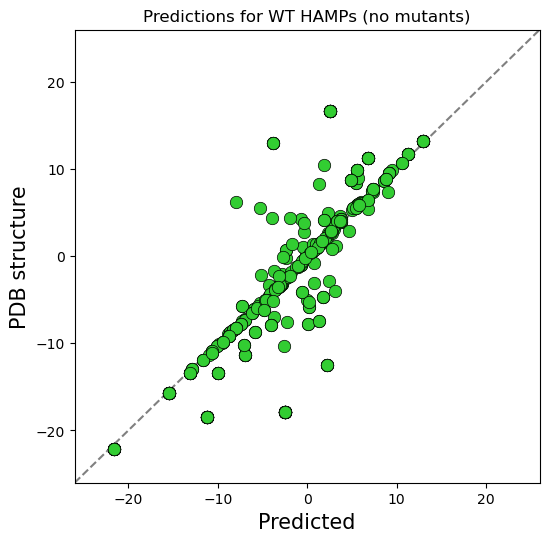

In [35]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(y_vpred_mean, y_val_mean, color='limegreen', s=80, lw=0.5, edgecolors='k')
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey', zorder=0)
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('PDB structure', size=15)
ax.set_title('Predictions for WT HAMPs (no mutants)')
pass

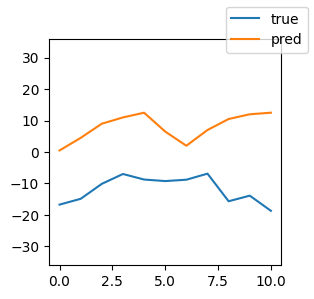

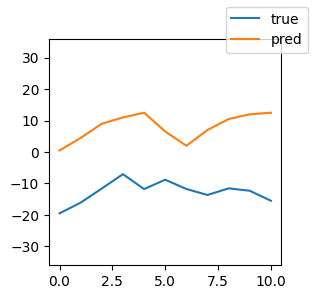

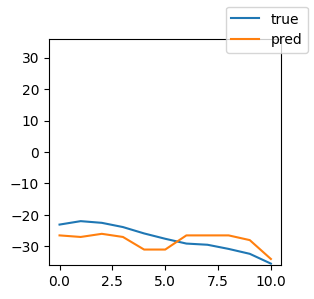

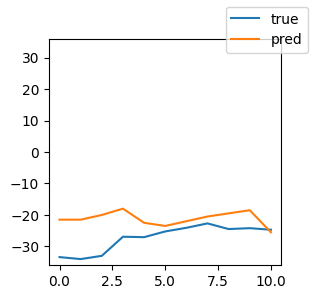

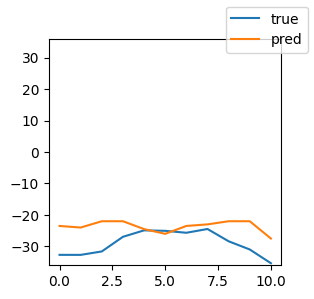

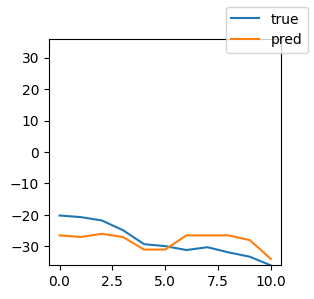

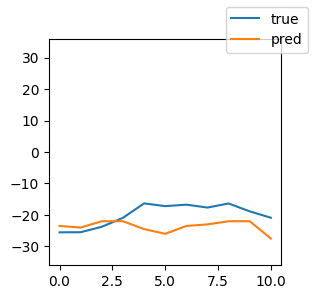

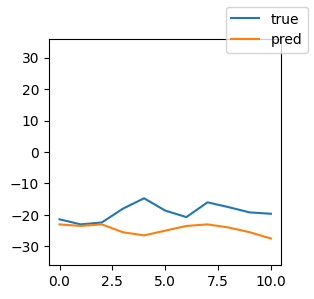

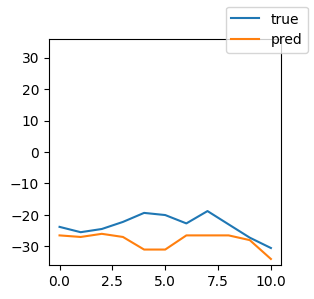

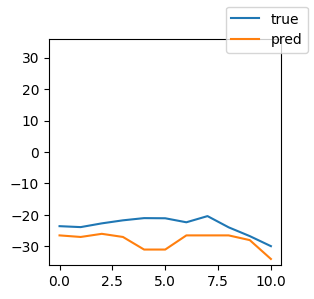

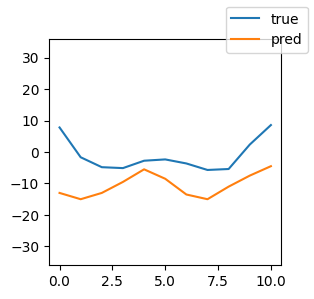

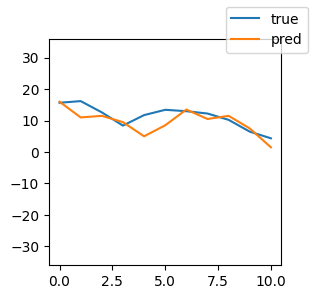

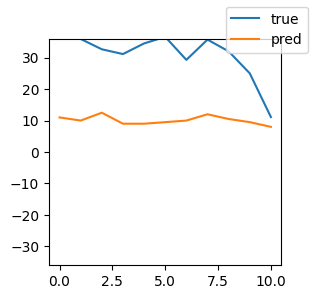

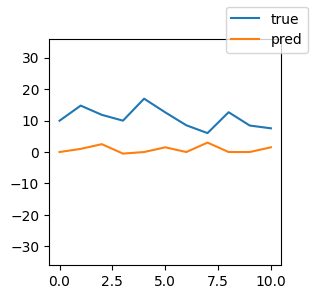

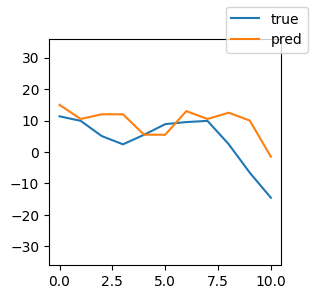

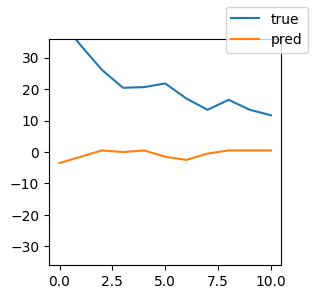

In [ ]:
for i in range(len(pdb_df)):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)

    ax.plot(y_test[i], label='true')
    ax.plot(y_pred[i], label='pred')
    ax.set_ylim(-36, 36)
    fig.legend(); pass
    #break

In [ ]:
#pd.read_pickle('../HAMPred/data/input/full_pdb_hamp.p')

In [ ]:
#pd.read_pickle('../HAMPred/data/input/full_alpha_data.p')

In [ ]:
# hamp_rot
# hamp_crick_ensemble
# two_helix_crdev
#model_name = 'hamp_rot'